# Objective.

To determine computationally which distribution the TPA follows for two ways of calculating it for the z-scan technique.

- Inverse function method.
- Regression method.

In [25]:
# LIBRARIES
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd

%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta


# Base functions used throughout the code

In [26]:
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def ruido(señal,desv): 
    '''
    Function to add Gaussian noise given a standard deviation

    Parameters
    ----------
    signal: Array
      Array with the signal to which the noise is to be added.
    dev: float
      Standard deviation
    '''
    señal_ruido=[np.random.normal(señal[i], señal[i]*desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)

def central(s,k):

    '''
    Function to verify central limit theorem

    Parameters
    -----------
    s: Array
     Array of data to which the theorem is to be applied.
    k: float
     Number of data to average

'''

    new_s=[]

    for i in range(0,len(s)):
        new_s.append(np.mean(np.random.choice(s,size=k)))
    return new_s

def confirm_gauss(s):
    result = (anderson(np.sort(s), dist='norm'))
    criterio=((result[0]<result[1][3])or(shapiro(np.sort(s))[1]>0.05))*1   
    return criterio
    


# Data assumed to be real:

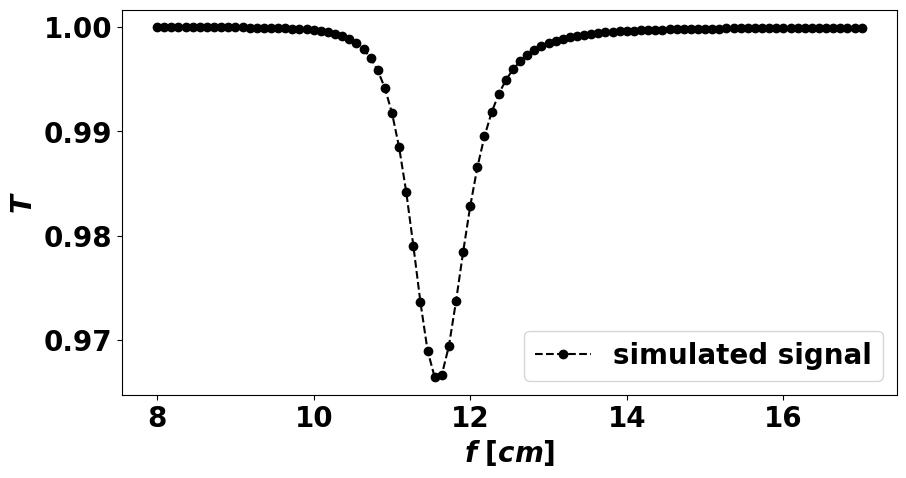

In [27]:
fig=plt.figure(figsize=(10,5))
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=np.linspace(8,17,100)*1e-2#focal distance [m]
beta = 3.4e-11 # TPA seed in (m/W )
L= 1.0e-3 # thickness in (m).
Pavg = 200e-3# Average power in (W)
Tp =  200e-15 # pulse width FWHM in (s)
wl =790e-9 #central wavelength in (m)
D = 2e-3 # beam diameter in (m)
ds = 116.0e-3# Distance EFTL-sample (m)a
Cf = 1.36 # beam correction coeff
alfa = 2.6e-1 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 90.6e6#Frecuencia en HZ

T=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
val_min=min(T)
index=T.index(min(T))

plt.plot(focal*100,T,'--ko',label='simulated signal')
#plt.plot(corriente,Td,'--ro',label='derivada')
plt.ylabel('$T$',fontsize=20)
plt.xlabel('$f$ $[cm]$',fontsize=20)
plt.legend()


En este notebook se estudia de forma sistematica, el ajuste del fenomeno de absorción de dos fotones bajo las dos perspectivas presentadas en el articulo.


# 1) Method 1.


In [19]:
def dist_betas(N,desv,k,par): 
    '''
    Parametros
    ----------
    N: float
        Numero de valores con los que se va a formar el histograma
    desv: float
        Arreglo con distancias focales utilizadas.
    k: float
        indice del arreglo de la distancia focal.
    par: array
        arreglo de 0 o 1 dependiendo de cual parametro se quiera investigar.
        [L,P,T,wl,D,ds,Cf,alpha,R,freq,trans,focal]

    La función devuelve la distribucion de beta
    '''
  # Cont,edra valores de TPA
    TPA=[]
    TT=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
    trans=TT[k] #Minimo de la señal simulada. 
    f=focal[k]  #Distancia focal correspondiente al minimo.   
    er=desv/(100)
    er_L=er*par[0]
    er_P=er*par[1]
    er_T=er*par[2]
    er_wl=er*par[3]
    er_D=er*par[4]
    er_ds=er*par[5]
    er_Cf=er*par[6]
    er_a=er*par[7]
    er_R=er*par[8]
    er_freq=er*par[9]
    er_trans=er*par[10]
    er_focal=er*par[11]
    # Randomly c
    for ii in range(N):


        L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
        Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
        Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
        wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
        D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
        ds_f = np.random.normal(ds,ds*er_ds,1) # EFTL-sample distance (m)
        Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
        alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
        R_f = np.random.normal(R,R*er_R,1) # Reflectance
        freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance
        trans_f= np.random.normal(trans,trans*er_trans,1)
        focal_f=np.random.normal(f,f*er_focal,1) 
        TPA.append(BETA(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)[0]*1e11)
      
    
    return TPA

# Variation of all parameters.

In [6]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
params=np.ones(12)
final=np.zeros((len(er_r),len(focal)))
for k in range(len(focal)):

    for c,j in enumerate(er_r):

        beta_hist=np.array(dist_betas(500,j,k,params))
        criterio=confirm_gauss(beta_hist)
        final[c,k]=criterio
        

([<matplotlib.axis.YTick at 0x7f0a650c3430>,
 [Text(0, 0, '0.0'),
  Text(0, 16, '1.62'),
  Text(0, 32, '3.24'),
  Text(0, 48, '4.85'),
  Text(0, 64, '6.47'),
  Text(0, 80, '8.08'),
  Text(0, 96, '9.7')])

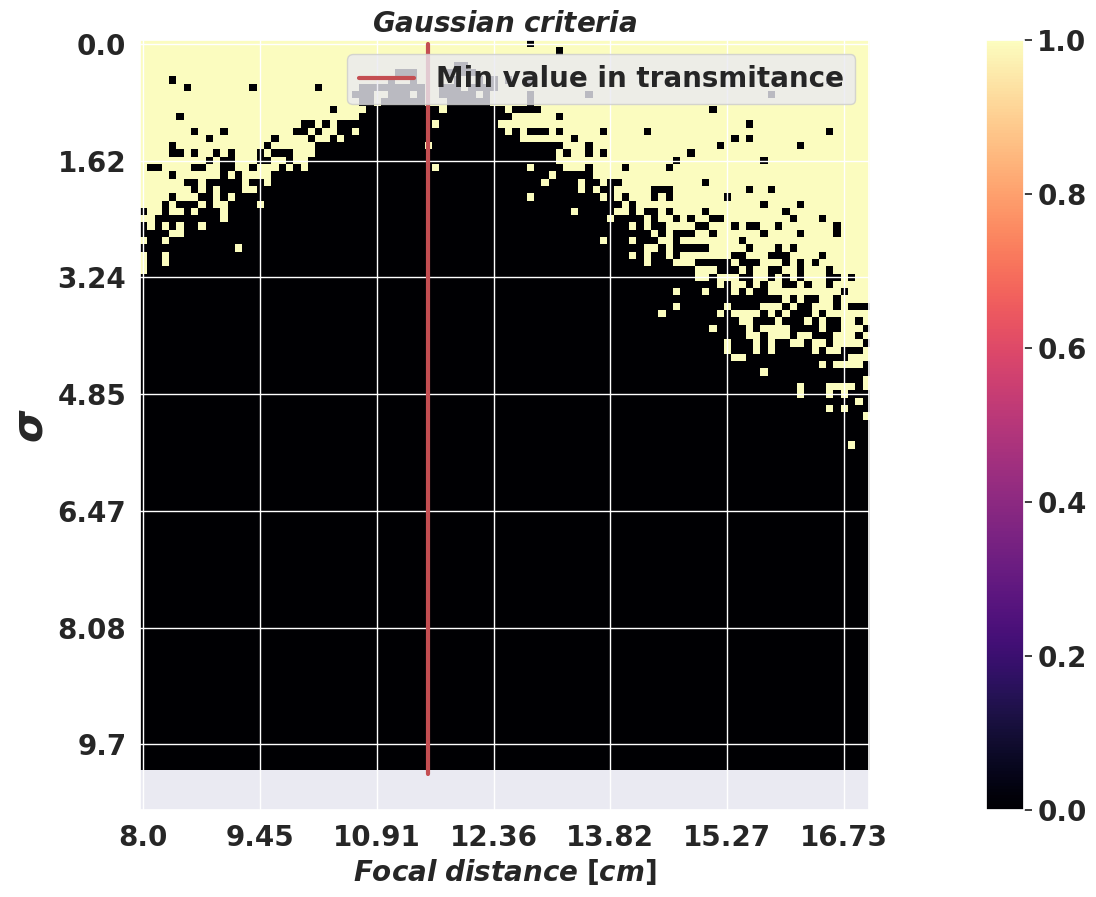

In [7]:
fig = plt.figure(figsize=(30,10))

er_r=np.linspace(0.005,10,100) #Porcentaje de error
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(final, cmap='magma')
plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
plt.ylabel('$\sigma$ ',fontsize=30)
plt.xlabel('$Focal$ $distance$ $[cm]$',fontsize=20)
plt.title('$Gaussian$ $criteria$',fontsize=20)
plt.legend(fontsize=20)
plt.colorbar()

nx = focal.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round(100*focal[::step_x],2) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)

ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],2) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)


# Variation in a single parameter:

In [28]:
results=[]
er_r=np.linspace(0.005,10,150) #Porcentaje de error
#params=np.diag(np.ones(12))
c1=np.zeros(12)
c1[4]=1
c2=np.zeros(12)
c2[5]=1
params=[c1,c2]

for i in params:

    final=np.zeros((len(er_r),len(focal)))

    for k in range(len(focal)):

        for c,j in enumerate(er_r):

            beta_hist=np.array(dist_betas(2000,j,k,i))
            criterio=confirm_gauss(beta_hist)
            final[c,k]=criterio
    
    results.append(final)


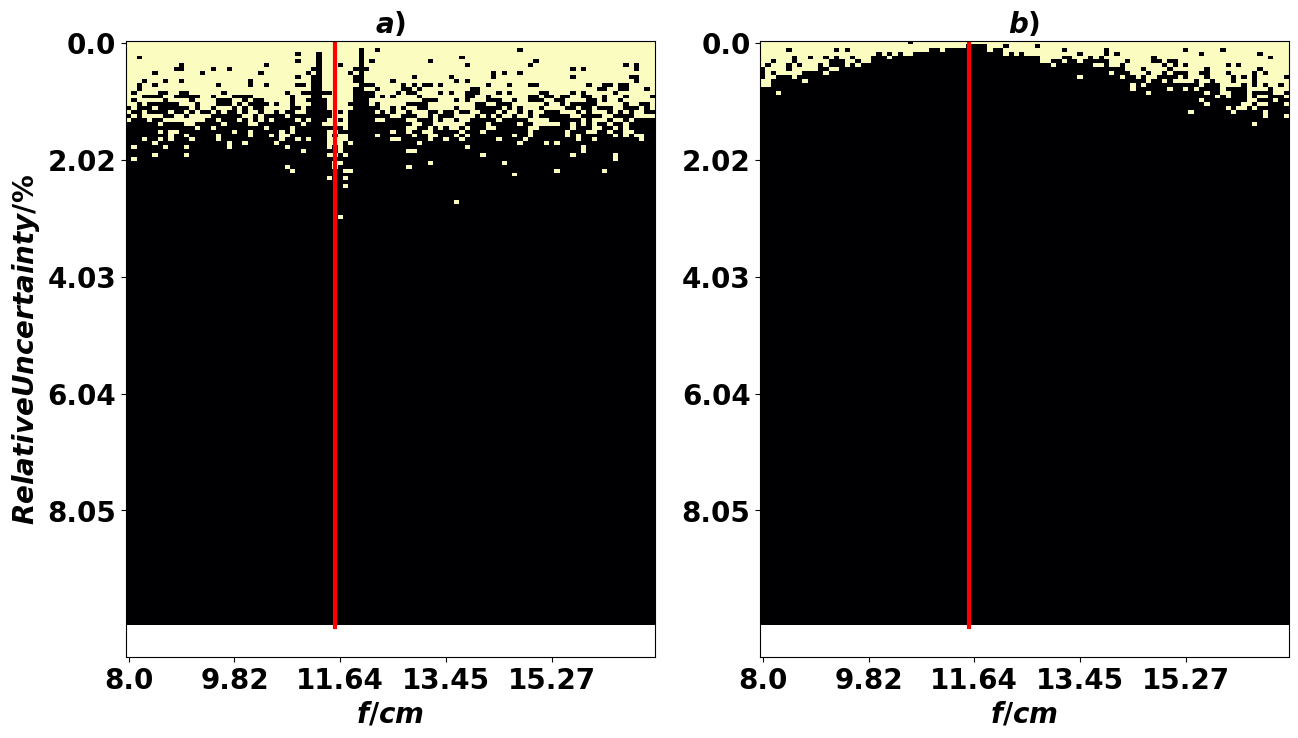

In [30]:
f=plt.figure(figsize=(15,8))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
#titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
titles=[r'$a)$',r'$b)$']
iters=1

for c,i in enumerate(results):

    plt.subplot(1,2,iters)

    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    plt.imshow(i, cmap='magma',interpolation='nearest', aspect='auto')
    plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
    if iters==1:
        plt.ylabel('$Relative Uncertainty/\%$',fontsize=20)
    plt.xlabel('$f/cm$',fontsize=20)
    plt.title(titles[c],fontsize=20)
    #plt.legend(fontsize=13)
 

    nx = focal.shape[0]
    no_labels = 6 # how many labels to see on axis x
    step_x = int(nx / (no_labels - 1)) # step between consecutive labels
    x_positions = np.arange(0,nx,step_x) # pixel count at label position
    x_labels = np.round(100*focal[::step_x],2) # labels you want to see
    plt.xticks(x_positions, np.sort(x_labels),fontsize=20)

    ny = er_r.shape[0]
    no_labels = 6 # how many labels to see on axis x
    step_y = int(ny / (no_labels - 1)) # step between consecutive labels
    y_positions = np.arange(0,ny,step_y) # pixel count at label position
    y_labels = np.round(er_r[::step_y],2) # labels you want to see
    plt.yticks(y_positions, np.sort(y_labels),fontsize=20)

    iters+=1

    

# Method 2.



In [5]:
def BETA2(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def dist_betas2(N,desv,params): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]
  er=desv/(1.96*100)
  
  for ii in range(N):
      
      TT=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
      er_L=er*params[0]
      er_P=er*params[1]
      er_T=er*params[2]
      er_wl=er*params[3]
      er_D=er*params[4]
      er_ds=er*params[5]
      er_Cf=er*params[6]
      er_a=er*params[7]
      er_R=er*params[8]
      er_freq=er*params[9]
      er_trans=er*params[10]
      er_focal=er*params[11]
      trans_f=ruido(TT,er_trans) #Minimo de la señal simulada. 
      focal_f=ruido(focal,er_focal)  #Distancia focal correspondiente al minimo.   
      
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
      D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
      ds_f = np.random.normal(ds,ds*er_ds,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
      R_f = np.random.normal(R,R*er_R,1) # Reflectance
      freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance
      
      
      TPA.append(BETA2(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)*1e11)
      
    
  return TPA


# Method 2: Variation in all parameters.

In [7]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,10,50) #Porcentaje de error
decis=[]

for j in er_r:
    
    beta_hist=np.array(dist_betas2(250,j,params))
    criterio=confirm_gauss(beta_hist)
    decis.append(criterio)

([<matplotlib.axis.XTick at 0x7ffa2dafcdf0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10')])

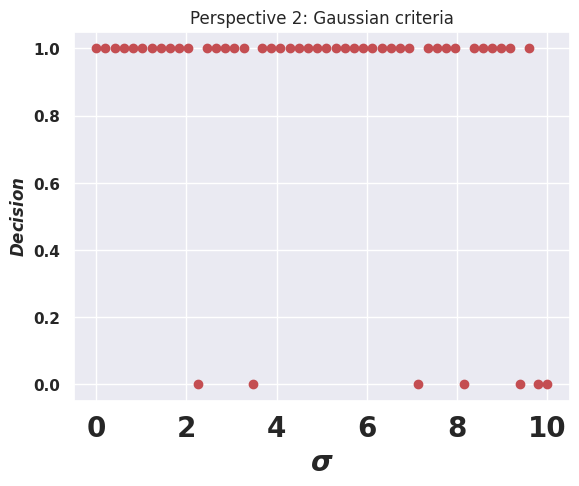

In [8]:
plt.plot(er_r,decis,'ro')
plt.xlabel('$\sigma$',fontsize=20)
plt.ylabel('$Decision$')
plt.title('Perspective 2: Gaussian criteria')
plt.xticks([0,2,4,6,8,10],fontsize=20)

# Variation in a single parameter:

In [9]:
results2=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
params=np.diag(np.ones(12))

for i in range(0,12):
    
    final=[]

    
    for c,j in enumerate(er_r):

        beta_hist=np.array(dist_betas2(500,j,params[i,:]))
        criterio=confirm_gauss(beta_hist)
        final.append(criterio)
    
    results2.append(final)


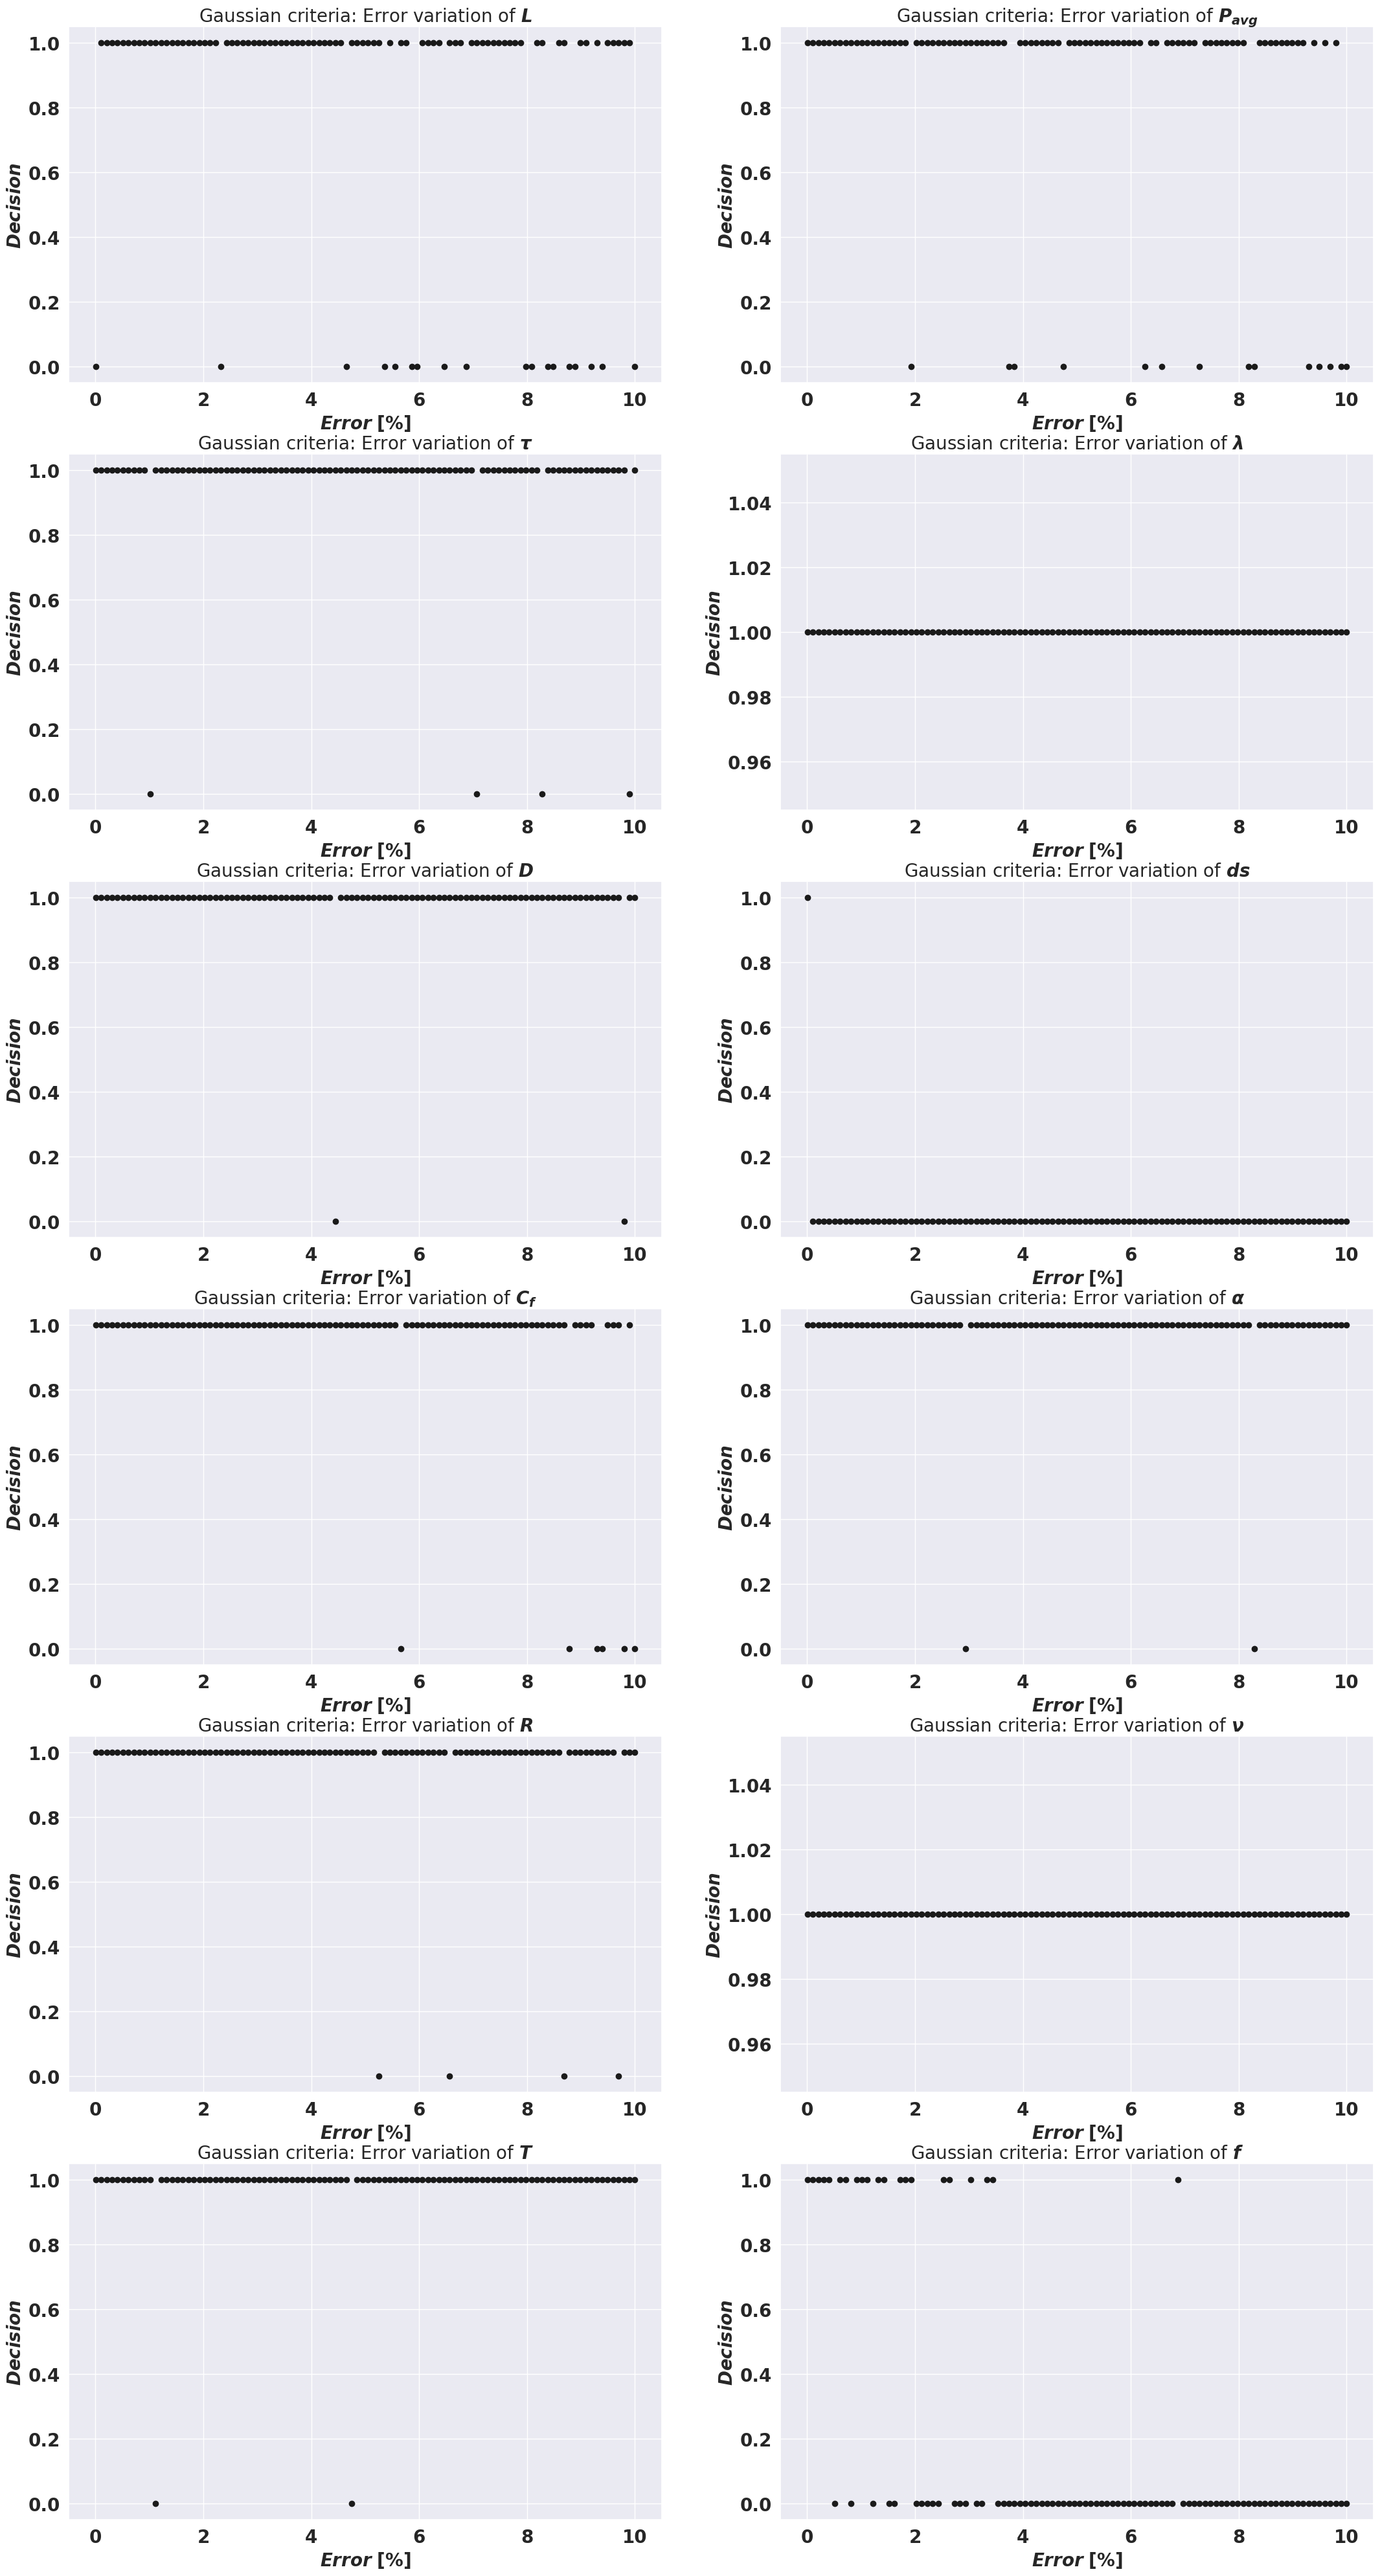

In [10]:
f=plt.figure(figsize=(26,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for c,i in enumerate(results2):

    plt.subplot(6,2,iters)
    plt.plot(er_r,i,'ko')
    plt.xlabel('$Error$ $[\%]$',fontsize=20)
    plt.ylabel('$Decision$',fontsize=20)
    plt.xticks([0,2,4,6,8,10],fontsize=20)
    plt.title(r'Gaussian criteria: Error variation of '+titles[c],fontsize=20)
    iters+=1
 

    